In [1]:
import numpy as np
import pandas as pd
import datetime
import pickle
import json

from Itin import *



In [2]:
itin = pd.read_csv('airdata/Itin 7-17.csv')
tmz = pd.read_csv('airdata/timezones.csv')
itin.rename(columns={'FlnSegArvlAirprt':'FlownSegArvlAirprt'},inplace=True)
tmz = tmz[['iata_code','iana_tz']]
tmzdct = tmz.set_index('iata_code').to_dict()['iana_tz']

In [3]:
fields = ['PlanSegDep','PlanSegArvl','FlownSegDep','FlownSegArvl','PlanODDep','PlanODArvl','FlownODDep','FlownODArvl']
for field in fields:
    itin[field] = pd.to_datetime(itin[field], format='%Y-%m-%d %H:%M:%S')

In [7]:
paxItins = {}
for i, row in itin.iterrows():
    id = row['PAX_PARTY_ID']
    if id not in paxItins:
        paxItins[id] = Itin(id)

    it = paxItins[id]
    loc = row['PlanSegDepAirprt']
    loc2 = row['PlanSegArvlAirprt']
    if not pd.isna(loc):
        it.addEvent(row['PlanSegDep'].tz_localize(tmzdct[loc]), loc, 1)
    if not pd.isna(loc2):
        it.addEvent(row['PlanSegArvl'].tz_localize(tmzdct[loc2]), loc2, 2)

for id in paxItins:
    paxItins[id].relabel()

In [8]:
flownPaxItins = {}
for i, row in itin.iterrows():
    id = row['PAX_PARTY_ID']
    if id not in flownPaxItins:
        flownPaxItins[id] = Itin(id)

    it = flownPaxItins[id]
    loc = row['FlownSegDepAirprt']
    loc2 = row['FlownSegArvlAirprt']
    if not pd.isna(loc):
        it.addEvent(row['FlownSegDep'].tz_localize(tmzdct[loc]), loc, 1)
    if not pd.isna(loc2):
        it.addEvent(row['FlownSegArvl'].tz_localize(tmzdct[loc2]), loc2, 2)

for id in flownPaxItins:
    flownPaxItins[id].relabel()

In [9]:
# Determine arrival at airport

for id in flownPaxItins:
    if not pd.isna(id):
        pax = itin[itin['PAX_PARTY_ID']==id]
        time = pax['PlanODDep'].iloc[0] 
        loc = pax['PlanODOrigin'].iloc[0]
        if not pd.isna(loc):
            flownPaxItins[id].addEvent(time.tz_localize(tmzdct[loc])-datetime.timedelta(hours=1), loc, 0)


In [ ]:
print(flownPaxItins[171683784.0].events[0])

In [11]:
start = datetime.datetime.fromisoformat('2019-07-17T00:00:00-04:00')
delta = datetime.timedelta(minutes=10)

In [12]:
trackedAirprt = ['MIA','SFO','DFW','CLT','ORD','JFK','LAS','LAX','BOS','BWI','DCA',
                 'PHX','SLC','HNL','IAH','SEA','ATL','JAX', 'LGA','PHL','PIT','OAK',
                 'DTW','MSP','SAN','DEN','FLL','MCO','TPA','AUS','STL','EWR','BNA',
                 'SNA','MCI']

dayData = []
for i in range(24*6):
    counts = countPax(start, trackedAirprt, flownPaxItins)
    dayData.append(counts)
    start += delta

    

In [13]:
with open('airdata/dayData.json','w') as file:
    file.write(json.dumps(dayData))

In [ ]:
start

In [16]:
dayData[60]

{'MIA': [2236, 0, 8, 3662, 649, 78],
 'SFO': [486, 0, 0, 0, 0, 0],
 'DFW': [2048, 2, 32, 5443, 459, 0],
 'CLT': [445, 2, 7, 2361, 571, 14],
 'ORD': [1977, 3, 0, 2374, 221, 0],
 'JFK': [576, 0, 140, 32, 1, 0],
 'LAS': [119, 0, 0, 0, 0, 0],
 'LAX': [1179, 0, 2, 151, 0, 0],
 'BOS': [368, 0, 3, 89, 14, 0],
 'BWI': [245, 0, 3, 14, 0, 0],
 'DCA': [777, 0, 0, 464, 144, 0],
 'PHX': [499, 0, 2, 742, 0, 0],
 'SLC': [55, 0, 0, 0, 0, 0],
 'HNL': [0, 0, 0, 0, 0, 0],
 'IAH': [136, 20, 7, 30, 0, 0],
 'SEA': [494, 0, 12, 0, 0, 0],
 'ATL': [102, 0, 0, 62, 0, 0],
 'JAX': [70, 0, 0, 28, 0, 0],
 'LGA': [416, 14, 0, 98, 80, 0],
 'PHL': [2060, 3, 10, 1563, 474, 0],
 'PIT': [144, 0, 0, 23, 0, 0],
 'OAK': [0, 0, 0, 0, 0, 0],
 'DTW': [185, 0, 2, 25, 0, 0],
 'MSP': [169, 0, 0, 45, 0, 0],
 'SAN': [454, 0, 2, 0, 0, 0],
 'DEN': [132, 0, 0, 20, 0, 0],
 'FLL': [141, 0, 0, 10, 0, 0],
 'MCO': [426, 0, 0, 28, 7, 0],
 'TPA': [130, 0, 0, 15, 31, 2],
 'AUS': [74, 0, 0, 20, 0, 0],
 'STL': [349, 0, 0, 26, 0, 0],
 'EWR': [29

In [2]:
with open('airdata/airprtLoc.json') as file:
    iataDct = json.loads(file.read())

In [3]:
with open('airdata/dayData.json') as file:
    dayData = json.loads(file.read())

In [12]:
with open('airdata/flownPaxItin.pkl', 'wb') as file:
    pickle.dump(flownPaxItins, file)
    file.close()

In [20]:
lat, long = iataDct['MIA']

In [40]:
import plotly.graph_objects as go
def make_frame(data, airDct):

    traces = []
    # For each airport: plot pie
    for airport in data:
        if airport != 'HNL':
            lat, lon = airDct[airport]
            ls = data[airport]
            size = np.sum(ls)
            labels = ['Arr 0-2', 'Arr 2-4', 'Arr 4+', 'Conn 0-2','Conn 2-4','Conn 4+']

            # The trick: plot as a Pie trace in a tiny inset domain
            # Compute a domain box around (lon, lat)
            # Map lon,lat to [0,1] for domain coordinates:
            # approximate: lon -125 to -65 -> 0 to 1, lat 25 to 50 -> 0 to 1

            domain_x = (lon + 130) / 70   # -125 to -65
            domain_y = (lat - 20) / 35    # 25 to 50

            scale = np.clip(size / 1000, 0.05, 0.2)  # adjust scale as needed

            traces.append(go.Pie(
                labels=labels,
                values=ls,
                hole=0.1,
                domain=dict(
                    x=[domain_x - scale/2, domain_x + scale/2],
                    y=[domain_y - scale/2, domain_y + scale/2]
                ),
                showlegend=False
            ))

    fig = go.Figure(data=traces)

    fig.update_layout(
    title='American Airlines Hub Passenger Flow',
    showlegend=False,
    geo=dict(
        scope='usa',
        projection_type='albers usa',
        showland=True,
        landcolor='rgb(217, 217, 217)',
        subunitcolor='rgb(255, 255, 255)',
        countrycolor='rgb(255, 255, 255)',
        lataxis=dict(range=[20, 55]),
        lonaxis=dict(range=[-130, -60]),
        center=dict(lat=39, lon=-98),
         )
        )

    return fig

In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [18]:
from matplotlib.patches import Wedge

def draw_pie(ax, ratios, X, Y, size):
    start = 0.
    colors = plt.cm.tab10.colors  # or pick your own
    for ratio, color in zip(ratios, colors):
        theta1 = start * 360
        theta2 = (start + ratio) * 360
        wedge = Wedge(center=(X, Y), r=size, theta1=theta1, theta2=theta2, facecolor=color, edgecolor='k')
        ax.add_patch(wedge)
        start += ratio

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def draw_pie(ax, ratios, X, Y, size):
    """
    Draw a pie chart at data coordinates (X, Y).
    """
    # 1. Transform data coordinates to axes fraction
    colors = plt.cm.tab10.colors 
    display_coords = ax.transData.transform((X, Y))
    inv = ax.transAxes.inverted()
    axes_coords = inv.transform(display_coords)

    # 2. Create inset axes at that position
    inset_ax = inset_axes(ax,
                          width=size,
                          height=size,
                          loc='center',
                          bbox_to_anchor=(axes_coords[0], axes_coords[1]),
                          bbox_transform=ax.transAxes,
                          borderpad=0)

    # 3. Make pie chart
    inset_ax.pie(ratios, colors=colors)
    inset_ax.set_aspect('equal')
    inset_ax.axis('off')

In [25]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,9))
ax = plt.axes(projection=ccrs.LambertConformal())
ax.set_extent([-130, -60, 20, 55])
ax.add_feature(cfeature.STATES, edgecolor='gray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

data = dayData[0]
for airport in data:
    lat, lon = iataDct[airport]
    size = np.sum(data[airport])
    if size > 0:
        ratios = np.asarray(data[airport])/size
        draw_pie(ax, ratios, lon, lat, size*5000)

plt.show()

ValueError: Image size of 88560014x88560014 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1440x648 with 16 Axes>

In [8]:
iataDct['MIA']

[25.793, -80.291]

In [9]:
iataDct['SFO']

[37.619, -122.375]

In [13]:
data['MIA']

[0, 33, 12, 0, 0, 0]

In [19]:
data = dayData[0]
for airport in data:
    values = np.asarray(data[airport])
    lat, lon = iataDct[airport]
    total = np.sum(values)
    ratios = values / total
    # Size: tune this factor to your liking
    size = 2 + total *10 # adjust scaling
    draw_pie(ax, ratios, lon, lat, size)

ax.set_title(f"Passenger categories at time ")
ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
ax.axis('off')

plt.show()

C:\Users\thewo\AppData\Local\Temp/ipykernel_31140/1724623915.py:6: RuntimeWarning: invalid value encountered in divide
  ratios = values / total


ValueError: cannot convert float NaN to integer

In [9]:
plt.show()

C:\Users\thewo\AppData\Local\Temp/ipykernel_18780/2148971404.py:42: RuntimeWarning:

invalid value encountered in divide



ValueError: cannot convert float NaN to integer

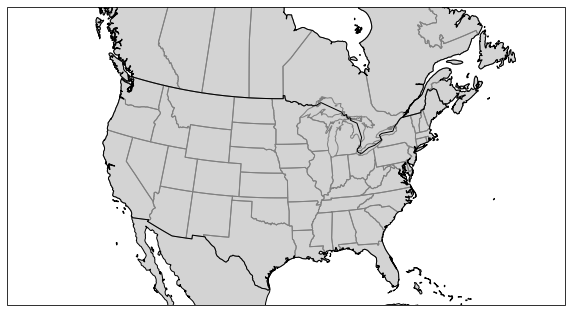

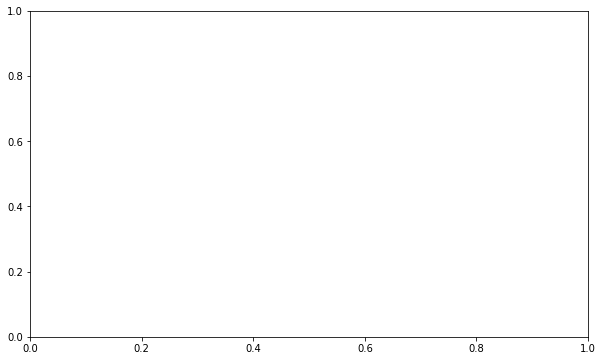

In [ ]:


# ---------------------------
# 3) Function to plot a pie chart at lon/lat
# ---------------------------


# ---------------------------
# 4) Generate frames
# ---------------------------
frames = []
fig, ax = plt.subplots(figsize=(10, 6))
data = dayData[0]


for airport in data:
    values = np.asarray(data[airport])
    lat, lon = iataDct[airport]
    total = np.sum(values)
    ratios = values / total
    # Size: tune this factor to your liking
    size = 2 + total *10 # adjust scaling
    draw_pie(ax, ratios, lon, lat, size)

ax.set_title(f"Passenger categories at time ")
ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
ax.axis('off')

plt.show()
#    filename = f"frame_{t:03d}.png"

144

In [48]:
make_frame(dayData[140], iataDct).show()

In [27]:
fig = make_frame(dayData[0], iataDct)
fig.show()

In [23]:
dayData[0]

{'MIA': [0, 33, 12, 0, 0, 0],
 'SFO': [0, 0, 0, 0, 0, 0],
 'DFW': [165, 29, 52, 0, 0, 0],
 'CLT': [0, 44, 30, 0, 0, 0],
 'ORD': [9, 7, 1, 0, 0, 0],
 'JFK': [0, 0, 7, 0, 0, 0],
 'LAS': [0, 0, 0, 0, 0, 0],
 'LAX': [16, 0, 9, 0, 0, 0],
 'BOS': [0, 0, 11, 0, 0, 0],
 'BWI': [0, 0, 0, 0, 0, 0],
 'DCA': [0, 2, 2, 0, 0, 0],
 'PHX': [5, 2, 1, 0, 0, 0],
 'SLC': [0, 0, 0, 0, 0, 0],
 'HNL': [0, 0, 0, 0, 0, 0],
 'IAH': [0, 0, 0, 0, 0, 0],
 'SEA': [0, 0, 13, 0, 0, 0],
 'ATL': [0, 0, 0, 0, 0, 0],
 'JAX': [0, 0, 0, 0, 0, 0],
 'LGA': [0, 3, 15, 0, 0, 0],
 'PHL': [0, 97, 7, 0, 0, 0],
 'PIT': [0, 0, 0, 0, 0, 0],
 'OAK': [0, 0, 0, 0, 0, 0],
 'DTW': [0, 0, 8, 0, 0, 0],
 'MSP': [0, 0, 0, 0, 0, 0],
 'SAN': [0, 0, 6, 0, 0, 0],
 'DEN': [0, 0, 0, 0, 0, 0],
 'FLL': [0, 0, 0, 0, 0, 0],
 'MCO': [0, 0, 0, 0, 0, 0],
 'TPA': [0, 0, 0, 0, 0, 0],
 'AUS': [0, 0, 0, 0, 0, 0],
 'STL': [0, 0, 2, 0, 0, 0],
 'EWR': [0, 0, 0, 0, 0, 0],
 'BNA': [0, 0, 0, 0, 0, 0],
 'SNA': [0, 0, 0, 0, 0, 0],
 'MCI': [0, 0, 0, 0, 0, 0]}